# Hourly grouping sentiment for Time series

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.offline as py
import plotly.express as px
import re
import nltk

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, RepeatVector
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam,RMSprop
from keras.layers import LSTM, TimeDistributed
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
df= pd.read_csv("../sahel_jul_aug_2020_en_clean_with_sentiment_date_sorted-Lip-cities.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34868 entries, 0 to 34867
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      34868 non-null  int64 
 1   created_at      34868 non-null  object
 2   date            34868 non-null  object
 3   year            34868 non-null  int64 
 4   month           34868 non-null  int64 
 5   day             34868 non-null  int64 
 6   hour            34868 non-null  int64 
 7   city            34868 non-null  object
 8   tweet           34868 non-null  object
 9   polarity        34868 non-null  object
 10  processed_text  34868 non-null  object
 11  y_pred          34868 non-null  int64 
 12  y_test          34868 non-null  int64 
 13  sentiment       34868 non-null  object
dtypes: int64(7), object(7)
memory usage: 3.7+ MB


In [82]:
df

,Unnamed: 0,created_at,date,year,month,day,hour,city,tweet,polarity,processed_text,y_pred,y_test,sentiment
0,25358,2020-06-01 02:12:22 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,Hi hi quickly enjoy for this online business t...,pos,hi hi quickly enjoy for this online business t...,1,1,pos
1,25357,2020-06-01 02:19:07 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,"@lance458 Allahumma amen. Thank you, i really ...",pos,<user> allahumma amen thank you i really app...,1,1,pos
2,34867,2020-06-01 02:20:13 CEST,2020-06-01 00:00:00,2020,6,1,2,Ouagadougou,With PGI,pos,with pgi,1,1,pos
3,25356,2020-06-01 02:42:05 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,"@SaifRikiji Serious, indeed",neg,<user> serious indeed,0,0,neg
4,25355,2020-06-01 02:43:03 CEST,2020-06-01 00:00:00,2020,6,1,2,Liptako,May Allah make it easy for us,pos,may allah make it easy for us,1,1,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34863,26267,2020-08-31 01:44:43 CEST,2020-08-31 00:00:00,2020,8,31,1,Ouagadougou,@Raadyalongo guys were all serious heavy ÃÂ°Ã...,neg,<user> guys were all serious heavy ...,1,0,pos
34864,3,2020-08-31 01:50:46 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@Al_ameen_yabo Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂidk,pos,<user> idk,0,1,neg
34865,2,2020-08-31 01:57:49 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@Sakinah_bawa @ stresses ne 2k,pos,<user> stresses ne 2k,1,1,pos
34866,1,2020-08-31 01:58:48 CEST,2020-08-31 00:00:00,2020,8,31,1,Liptako,@ Jishaq1 @SKawaah_Bawa Haba Bross don't fall ...,pos,jishaq1 <user> haba bross do not fall for ou...,1,1,pos


###### Remove unnecessary columns

In [83]:
df_1 = df[['created_at','month','day','hour','y_pred','processed_text']]

In [84]:
df_1

,created_at,month,day,hour,y_pred,processed_text
0,2020-06-01 02:12:22 CEST,6,1,2,1,hi hi quickly enjoy for this online business t...
1,2020-06-01 02:19:07 CEST,6,1,2,1,<user> allahumma amen thank you i really app...
2,2020-06-01 02:20:13 CEST,6,1,2,1,with pgi
3,2020-06-01 02:42:05 CEST,6,1,2,0,<user> serious indeed
4,2020-06-01 02:43:03 CEST,6,1,2,1,may allah make it easy for us
...,...,...,...,...,...,...
34863,2020-08-31 01:44:43 CEST,8,31,1,1,<user> guys were all serious heavy ...
34864,2020-08-31 01:50:46 CEST,8,31,1,0,<user> idk
34865,2020-08-31 01:57:49 CEST,8,31,1,1,<user> stresses ne 2k
34866,2020-08-31 01:58:48 CEST,8,31,1,1,jishaq1 <user> haba bross do not fall for ou...


In [85]:
df_1['count'] = 1

<ipython-input-85-c72318be8606>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
df_1

,created_at,month,day,hour,y_pred,processed_text,count
0,2020-06-01 02:12:22 CEST,6,1,2,1,hi hi quickly enjoy for this online business t...,1
1,2020-06-01 02:19:07 CEST,6,1,2,1,<user> allahumma amen thank you i really app...,1
2,2020-06-01 02:20:13 CEST,6,1,2,1,with pgi,1
3,2020-06-01 02:42:05 CEST,6,1,2,0,<user> serious indeed,1
4,2020-06-01 02:43:03 CEST,6,1,2,1,may allah make it easy for us,1
...,...,...,...,...,...,...,...
34863,2020-08-31 01:44:43 CEST,8,31,1,1,<user> guys were all serious heavy ...,1
34864,2020-08-31 01:50:46 CEST,8,31,1,0,<user> idk,1
34865,2020-08-31 01:57:49 CEST,8,31,1,1,<user> stresses ne 2k,1
34866,2020-08-31 01:58:48 CEST,8,31,1,1,jishaq1 <user> haba bross do not fall for ou...,1


##### Grouping by hour

In [87]:
#grouped by hour
data_filtered = df_1[['month', 'day', 'hour','y_pred','count']]

In [88]:
df_tweets_hour_grouped = data_filtered.groupby(['month', 'day','hour']).sum().reset_index()
df_tweets_hour_grouped.head(10)

,month,day,hour,y_pred,count
0,6,1,2,5,6
1,6,1,3,13,17
2,6,1,4,5,5
3,6,1,5,0,1
4,6,1,6,3,4
5,6,1,7,14,17
6,6,1,8,17,20
7,6,1,9,27,33
8,6,1,10,16,21
9,6,1,11,13,16


In [89]:
df_tweets_hour_grouped['pos'] = df_tweets_hour_grouped['y_pred']

In [90]:
df_tweets_hour_grouped['neg'] = df_tweets_hour_grouped['count'] - df_tweets_hour_grouped['y_pred']

In [91]:
df_tweets_hour_grouped

,month,day,hour,y_pred,count,pos,neg
0,6,1,2,5,6,5,1
1,6,1,3,13,17,13,4
2,6,1,4,5,5,5,0
3,6,1,5,0,1,0,1
4,6,1,6,3,4,3,1
...,...,...,...,...,...,...,...
2129,8,30,21,21,26,21,5
2130,8,30,22,10,13,10,3
2131,8,30,23,12,12,12,0
2132,8,31,0,27,30,27,3


In [92]:
import datetime

In [93]:
df_tweets_hour_grouped

,month,day,hour,y_pred,count,pos,neg
0,6,1,2,5,6,5,1
1,6,1,3,13,17,13,4
2,6,1,4,5,5,5,0
3,6,1,5,0,1,0,1
4,6,1,6,3,4,3,1
...,...,...,...,...,...,...,...
2129,8,30,21,21,26,21,5
2130,8,30,22,10,13,10,3
2131,8,30,23,12,12,12,0
2132,8,31,0,27,30,27,3


In [94]:
new_df=df_tweets_hour_grouped.assign(date=0)

In [95]:
new_df

,month,day,hour,y_pred,count,pos,neg,date
0,6,1,2,5,6,5,1,0
1,6,1,3,13,17,13,4,0
2,6,1,4,5,5,5,0,0
3,6,1,5,0,1,0,1,0
4,6,1,6,3,4,3,1,0
...,...,...,...,...,...,...,...,...
2129,8,30,21,21,26,21,5,0
2130,8,30,22,10,13,10,3,0
2131,8,30,23,12,12,12,0,0
2132,8,31,0,27,30,27,3,0


In [96]:
for i in new_df.index:
    new_df['date'][i] = datetime.datetime(2020, df_tweets_hour_grouped['month'][i], df_tweets_hour_grouped['day'][i], df_tweets_hour_grouped['hour'][i])


<ipython-input-96-dbdff9264dd4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
new_df

,month,day,hour,y_pred,count,pos,neg,date
0,6,1,2,5,6,5,1,2020-06-01 02:00:00
1,6,1,3,13,17,13,4,2020-06-01 03:00:00
2,6,1,4,5,5,5,0,2020-06-01 04:00:00
3,6,1,5,0,1,0,1,2020-06-01 05:00:00
4,6,1,6,3,4,3,1,2020-06-01 06:00:00
...,...,...,...,...,...,...,...,...
2129,8,30,21,21,26,21,5,2020-08-30 21:00:00
2130,8,30,22,10,13,10,3,2020-08-30 22:00:00
2131,8,30,23,12,12,12,0,2020-08-30 23:00:00
2132,8,31,0,27,30,27,3,2020-08-31 00:00:00


In [98]:
df_tweets_hour_grouped = new_df

In [99]:
df_tweets_hour_grouped

,month,day,hour,y_pred,count,pos,neg,date
0,6,1,2,5,6,5,1,2020-06-01 02:00:00
1,6,1,3,13,17,13,4,2020-06-01 03:00:00
2,6,1,4,5,5,5,0,2020-06-01 04:00:00
3,6,1,5,0,1,0,1,2020-06-01 05:00:00
4,6,1,6,3,4,3,1,2020-06-01 06:00:00
...,...,...,...,...,...,...,...,...
2129,8,30,21,21,26,21,5,2020-08-30 21:00:00
2130,8,30,22,10,13,10,3,2020-08-30 22:00:00
2131,8,30,23,12,12,12,0,2020-08-30 23:00:00
2132,8,31,0,27,30,27,3,2020-08-31 00:00:00


In [100]:
df_tweets_hour_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2134 entries, 0 to 2133
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   month   2134 non-null   int64 
 1   day     2134 non-null   int64 
 2   hour    2134 non-null   int64 
 3   y_pred  2134 non-null   int64 
 4   count   2134 non-null   int64 
 5   pos     2134 non-null   int64 
 6   neg     2134 non-null   int64 
 7   date    2134 non-null   object
dtypes: int64(7), object(1)
memory usage: 133.5+ KB


In [24]:
df_tweets_hour_grouped.to_csv('sahel_jun_aug_2020_grouped_sentiment-lip-cities.csv')

In [25]:
df = df_tweets_hour_grouped

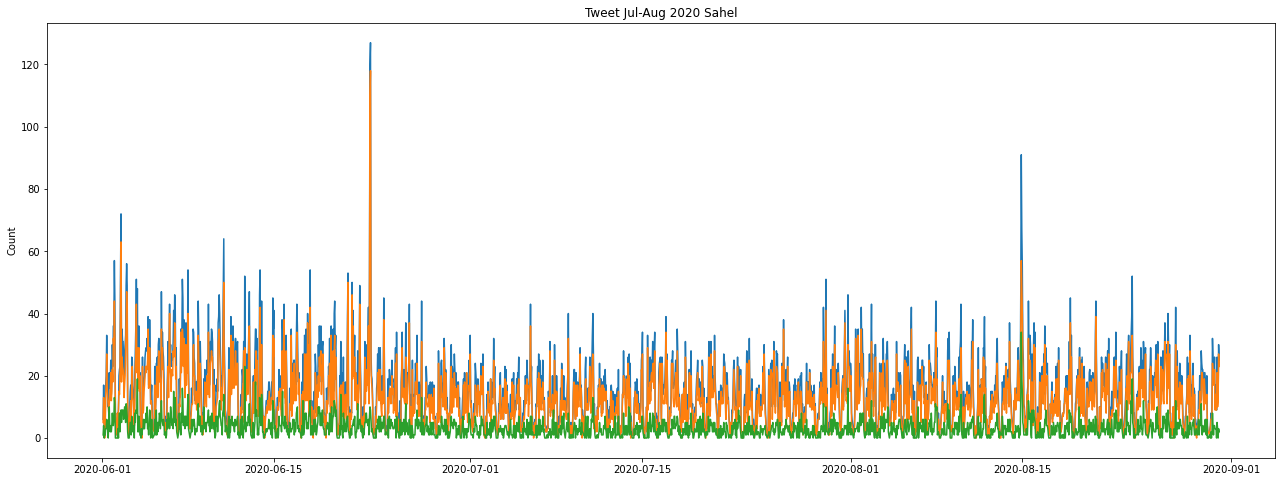

In [26]:
f = plt.figure()
f.set_figwidth(22)
f.set_figheight(8)
#plt.xticks(rotation = 'vertical')
plt.title('Tweet Jul-Aug 2020 Sahel')
plt.ylabel('Count')
#ax1 = plt.subplot()
#ax1.set_xticks(np.arange(len(df['date'])))
#ax1.set_xticklabels(df['date'], rotation=45)
#plt.xticks(np.arange(len(df['date'])))
#plt.xticklabels(df['date'])
#plt.xticks(df['date'])
plt.plot(df.groupby(df["date"]).sum()["count"])#blu
plt.plot(df.groupby(df["date"]).sum()["pos"])#arancio
plt.plot(df.groupby(df["date"]).sum()["neg"])#verde

In [27]:
import plotly.express as px
import plotly.graph_objects as go

In [78]:
layout = go.Layout(
    width=1000,
    height=600,

)
fig = go.Figure(layout=layout)
fig.update_xaxes(dtick="0")
fig.add_trace(go.Scatter(x=df['date'], y=df['count'],
                    mode='lines',
                    name='Total'))
fig.add_trace(go.Scatter(x=df['date'], y=df['neg'],
                    mode='lines',
                    name='Neg'))
fig.add_trace(go.Scatter(x=df['date'], y=df['pos'],
                    mode='lines',
                    name='Pos'))
fig.update_layout(
   title = "Sentiment hourly Trend",
   xaxis_title = "date",
   yaxis_title = "count",
   font = dict(
      family = "Courier New, monospace",
      size = 10,
      color = "#7f7f7f"
   )
)
fig.show()

In [77]:
layout = go.Layout(
    width=1000,
    height=600
)
fig = go.Figure(layout=layout)
fig.update_xaxes(dtick="0")
fig.add_trace(go.Scatter(x=df['date'], y=df['neg'],
                    mode='lines',
                    name='Neg'))
fig.update_layout(
   title = "Negative Sentiment Trend",
   xaxis_title = "date",
   yaxis_title = "count",
   font = dict(
      family = "Courier New, monospace",
      size = 10,
      color = "#7f7f7f"
   )

)
fig.data[0].line.color = '#EF553B'
fig.show()